# <b>ExxonMobil</b> 
# Årsrapporter og nyhetsartikler

### Imports osv

In [204]:
# Installing packages
!pip install webdriver-manager selenium hdbscan beautifulsoup4 keybert pycryptodome sentence-transformers PyPDF2 --quiet

# Importing the transformer
from sentence_transformers import SentenceTransformer

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sc
import requests
import torch
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from sklearn.manifold import TSNE
from keybert import KeyBERT
from sklearn.decomposition import PCA   

# Special imports for plots
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


# Imports for the widgets
from ipywidgets import widgets, interact
from IPython.display import display, clear_output

#Imports for decrypting urls to pdfs or html
from urllib.parse import urljoin
import re
import requests
import PyPDF2
from bs4 import BeautifulSoup
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /opt/anaconda3/envs/embed/lib/python3.12/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


# Nyhetsartikler

In [46]:

article_links = []

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize WebDriver (e.g., for Chrome)
driver = webdriver.Chrome()

def read_urls(url, year):
    driver.get(url)
    
     # Wait for the page to load and continue clicking "Load More" until no more are found
    while True:
        try:
            load_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'button.load-more'))
            )
            load_more_button.click()
            time.sleep(2)  # Wait for content to load
        except Exception as e:
            print(f"No more 'Load More' button found or error occurred: {e}")
            break  # No more "Load More" button found

    soup = BeautifulSoup(driver.page_source, "html.parser")
    for a in soup.find_all('a', href=True):
        href = a['href']
        if href.startswith('/news/news-releases/'):
            full_url = f"https://corporate.exxonmobil.com{href}"
            if full_url not in article_links:
                # Extract the year from the link text or nearby elements
                article_year = href.split('/')[3]
                if article_year == str(year):
                    article_links.append(full_url)
            else:
                print(f"Duplicate found: {full_url}")

def read_year(year):
    news = "https://corporate.exxonmobil.com/news/news-releases"
    read_urls(news, year)



def extract_article_content(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Initialize content variable
    article_content = ""

    # Extract content from specified divs
    prose_md = soup.find("div", {"class": "prose-md"})
    prose_article = soup.find("div", {"class": "prose-article"})

    if prose_md:
        article_content += prose_md.text.strip()
    if prose_article:
        article_content += prose_article.text.strip()
    
    # If no content was found in the specific divs, try more generic extraction
    if not article_content:
        main_content = soup.find("main")
        if main_content:
            article_content += main_content.text.strip()

    # If still no content, try extracting text from all divs, excluding known irrelevant sections
    if not article_content:
        all_divs = soup.find_all("div")
        for div in all_divs:
            # Exclude navigation, footer, and sidebar sections
            if 'nav' in div.get('class', []) or 'footer' in div.get('class', []) or 'sidebar' in div.get('class', []):
                continue
            text = div.get_text(separator=' ', strip=True)
            if text:
                article_content += text + " "

    # If content is still empty, log a message
    if not article_content:
        print(f"No content found for URL: {url}")

    return article_content


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time

def get_all_urls():
    options = Options()
    options.headless = True  # Run headless Chrome for efficiency
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    base_url = "https://corporate.exxonmobil.com/news/news-releases"
    driver.get(base_url)
    
    wait = WebDriverWait(driver, 10)
    
    while True:
        try:
            load_more_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button.contentCollection--loadMore.button-loadMore')))
            load_more_button.click()
            time.sleep(2)  # Wait for the next set of articles to load
        except Exception as e:
            break  # Exit loop when no more "Load More" button is found
    
    # Collect all article URLs
    urls = set()
    articles = driver.find_elements(By.CSS_SELECTOR, 'div.contentCollection--item a[href^="/news/news-releases/"]')
    for article in articles:
        urls.add(article.get_attribute('href'))
    
    driver.quit()
    return list(urls)

# Get all URLs
urls = get_all_urls()

# Print all collected URLs
for url in urls:
    print(url)

print(len(urls))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

https://corporate.exxonmobil.com/news/news-releases/2021/0201_exxonmobil-low-carbon-solutions-to-commercialize-emission-reduction-technology
https://corporate.exxonmobil.com/news/news-releases/2019/1223_exxonmobil-discovers-oil-offshore-guyana-at-mako-1-well
https://corporate.exxonmobil.com/news/news-releases/2018/0606_exxonmobil-completes-purchase-of-carcara-oil-field-interest
https://corporate.exxonmobil.com/news/news-releases/2017/0419_exxonmobil-and-sabic-select-san-patricio-county-proposed-petrochemical-project-us-gulf-coast
https://corporate.exxonmobil.com/news/news-releases/2017/1025_exxon-mobil-corporation-declares-fourth-quarter-dividend
https://corporate.exxonmobil.com/news/news-releases/2019/1101_exxonmobil-earns-3_2-billion-in-third-quarter-2019
https://corporate.exxonmobil.com/news/news-releases/2019/0418_exxonmobil-announces-13th-discovery-offshore-guyana
https://corporate.exxonmobil.com/news/news-releases/2017/0309_exxonmobil-to-acquire-25-percent-interest-in-mozambique-

In [61]:
articles_by_year = {}

for url in urls:
    year = url[52:56]
    if year.isdigit():  # Check if the year contains only digits
        if year not in articles_by_year:
            articles_by_year[year] = []
        articles_by_year[year].append(url)

for year in articles_by_year:
    print(f"{year}: Number of articles = {len(articles_by_year[year])}")

2021: Number of articles = 61
2019: Number of articles = 70
2018: Number of articles = 85
2017: Number of articles = 87
2020: Number of articles = 58
2022: Number of articles = 56
2024: Number of articles = 8
2016: Number of articles = 63
2023: Number of articles = 20


In [65]:
def fetch_page_content(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    content = []
    
    # Extract the title and introduction
    header_content = soup.find('article', {'class': 'articleHeader--content'})
    if header_content:
        content.append(header_content.get_text(separator=' ', strip=True))
    
    # Extract rich text sections
    rich_text_sections = soup.find_all('section', {'class': 'rich-text'})
    for section in rich_text_sections:
        content.append(section.get_text(separator=' ', strip=True))
    
    # Extract topic container sections without images
    topic_containers = soup.find_all('section', {'class': 'topicContainer topicContainer--article'})
    for container in topic_containers:
        text_content = container.find_all(['div', 'p', 'h2', 'h3', 'h4', 'ul', 'ol'], recursive=True)
        for item in text_content:
            content.append(item.get_text(separator=' ', strip=True))
    
    return ', '.join(content)

In [66]:
# Extract Article Content by Year
def extract_articles_content(articles_by_year):
    articles_content_by_year = {}

    for year, urls in articles_by_year.items():
        articles_content_by_year[year] = []
        for url in urls:
            content = fetch_page_content(url)
            articles_content_by_year[year].append(content)

    return articles_content_by_year

In [68]:
# Example usage for extracting article content
articles_content_by_year = extract_articles_content(articles_by_year)

"""
for year, articles in articles_content_by_year.items():
    print(f"Articles for {year}:")
    for article in articles:
        print(f"- {article}")
"""

articles_content_by_year



{'2021': ['ExxonMobil Low Carbon Solutions to commercialize emission-reduction technology IRVING, Texas – ExxonMobil said today it has created a new business to commercialize its extensive low-carbon technology portfolio. The new business, ExxonMobil Low Carbon Solutions, will initially focus on carbon capture and storage, one of the critical technologies required to achieve net zero emissions and the climate goals outlined in the Paris Agreement. News releases Feb. 1, 2021, New business to commercialize and deploy technology from extensive, industry-leading R&D portfolio Initial focus on carbon capture and storage (CCS), a technology recognized as critical to achieving Paris Agreement climate goals Advancing plans for over 20 new CCS opportunities to enable large-scale emission reductions ExxonMobil Low Carbon Solutions is advancing plans for more than 20 new carbon capture and storage opportunities around the world to enable large-scale emission reductions. ExxonMobil plans to invest

In [1]:
def split_up_text(article, n): #husk at n må være mindre enn 512 (helst 500) for at modellen skal bruke hele!
    words = article.strip().split()
    if len(words) <= n :
        return [article]
    else:
        new_article = []
        for i in range(0, len(words), n):
            chunk = words[i:i+n]
            new_article.append(' '.join(chunk))
        return new_article

In [2]:
def split_articles_content_by_year(articles_content_by_year, n):
    split_articles_by_year = {}  # Define inside the function

    for year, articles in articles_content_by_year.items():
        split_articles_by_year[year] = []
        for article in articles:
            split_content = split_up_text(article, n)
            split_articles_by_year[year].extend(split_content)

    return split_articles_by_year  # Return the dictionary

split_content = split_articles_content_by_year(articles_content_by_year,400)

NameError: name 'articles_content_by_year' is not defined

In [477]:
with open("Exxon_split_articles.pkl","wb") as file:
    pickle.dump(split_content, file)

In [188]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [79]:
def embed_text(t): # obs dette tar lang tid
    embeddings = model.encode(t, convert_to_tensor=True)
    return embeddings

In [84]:
embed_2024 = embed_text(split_content["2024"])
print(embed_2024)
embed_2024.shape

tensor([[ 0.3386,  0.5018, -0.4473,  ..., -1.0695,  0.1364,  0.1460],
        [-0.1542,  0.9160,  0.3055,  ..., -0.9037, -0.4507,  0.0948],
        [-0.1012,  0.3305, -0.0896,  ..., -0.9392, -0.6672,  0.1993],
        ...,
        [-0.4813,  0.4423, -0.4435,  ..., -1.0133, -0.3533,  0.2838],
        [-0.4451,  0.9746, -0.0802,  ..., -1.1426, -0.6748,  0.1571],
        [-0.2819,  0.1447,  0.4058,  ..., -0.6203, -0.4662, -0.2783]])


torch.Size([38, 1024])

In [85]:
embed_2023 = embed_text(split_content["2023"])
print(embed_2023)
embed_2023.shape

tensor([[-0.0511,  0.5002, -0.0788,  ..., -0.8763, -1.0258,  0.2946],
        [-0.3196,  0.7013,  0.2198,  ..., -0.6384, -0.6229,  0.1740],
        [ 0.0384,  0.8748,  0.2277,  ..., -0.6323, -0.5528,  0.1498],
        ...,
        [-0.6400,  0.1183,  0.2458,  ..., -0.3920, -0.2491, -0.3331],
        [-0.2145,  0.3761,  0.6032,  ..., -0.3383, -0.3308, -0.0101],
        [-0.3734, -0.2380,  0.1376,  ..., -0.8441, -0.0612, -0.0427]])


torch.Size([97, 1024])

In [86]:
embed_2022 = embed_text(split_content["2022"])
print(embed_2022)
embed_2022.shape

tensor([[-0.1931,  0.5389,  0.1108,  ..., -0.5514, -0.5852,  0.0201],
        [-0.2709,  0.6745, -0.0688,  ..., -0.4613, -0.2115,  0.1832],
        [ 0.3057,  0.1215, -0.1919,  ..., -0.7956, -0.3654,  0.4210],
        ...,
        [-0.4972,  0.6230, -0.1374,  ..., -0.6259, -0.6373,  0.0148],
        [-0.2625,  0.6203,  0.3454,  ..., -0.3679, -0.4574,  0.1643],
        [-0.5801,  0.1957, -0.2246,  ..., -0.6243, -0.2131,  0.2796]])


torch.Size([157, 1024])

In [87]:
embed_2021 = embed_text(split_content["2021"])
print(embed_2021)
embed_2021.shape

tensor([[-0.0716,  0.5957,  0.6938,  ..., -0.7166, -0.6292,  0.5077],
        [ 0.1835,  0.5944,  0.3845,  ..., -1.0614, -0.3605,  0.2924],
        [-0.3246,  0.6263,  0.5070,  ..., -0.9633, -0.1036, -0.1174],
        ...,
        [ 0.2218,  0.8180, -0.2818,  ..., -1.3138, -0.1206,  0.2515],
        [ 0.3347,  0.9054, -0.3741,  ..., -1.0267,  0.3392,  0.1296],
        [-0.0221,  0.1462, -0.6377,  ..., -0.0953, -0.0115,  0.6848]])


torch.Size([170, 1024])

In [88]:
embed_2020 = embed_text(split_content["2020"])
print(embed_2020)
embed_2020.shape

tensor([[-0.3209,  0.9477, -0.0580,  ..., -0.9300, -0.4979,  0.7189],
        [-0.2802, -0.0061, -0.1670,  ..., -0.2767, -0.3439, -0.1590],
        [-0.0387,  0.6692, -0.0528,  ..., -0.8337,  0.3206,  0.3016],
        ...,
        [-0.4789,  0.8129,  0.3646,  ..., -1.0872, -0.5265,  0.1512],
        [-0.5332,  0.7897,  0.2921,  ..., -0.8967, -0.3667,  0.1091],
        [-0.4146,  0.6385, -0.1094,  ..., -0.6958, -0.6465, -0.4346]])


torch.Size([134, 1024])

In [89]:
embed_2019 = embed_text(split_content["2019"])
print(embed_2019)
embed_2019.shape

tensor([[ 0.2249,  1.2363, -0.3603,  ..., -1.3897, -0.2462,  0.3181],
        [-0.2509,  0.5036,  0.1569,  ..., -0.6523,  0.1936, -0.0199],
        [-0.4300,  0.5716,  0.3857,  ..., -1.0969, -1.1900,  0.0415],
        ...,
        [-0.4554,  0.5044,  0.2249,  ..., -0.0707, -0.2897, -0.0187],
        [-0.5276,  0.3389,  0.2042,  ..., -0.0215, -0.2114,  0.0453],
        [-0.6186,  0.2711, -0.0540,  ...,  0.0695, -0.0254,  0.2322]])


torch.Size([154, 1024])

In [90]:
embed_2018 = embed_text(split_content["2018"])
print(embed_2018)
embed_2018.shape

tensor([[-2.8753e-02,  1.3995e+00, -1.8622e-02,  ..., -2.5338e-01,
         -9.1341e-01,  5.5825e-01],
        [-8.6318e-02,  1.7310e-01,  3.2813e-01,  ..., -6.4488e-01,
          1.1523e-01, -1.6280e-04],
        [-7.2925e-01,  3.9031e-01,  3.3262e-01,  ..., -9.2687e-01,
         -2.2695e-01, -5.7521e-02],
        ...,
        [-4.0147e-01,  1.2253e+00,  2.2416e-01,  ..., -9.0211e-01,
         -9.4844e-01,  5.1389e-02],
        [-2.7243e-01,  5.9897e-01,  5.6695e-01,  ..., -5.8604e-01,
         -1.0470e+00,  1.9456e-01],
        [-4.7627e-01,  2.3093e-01,  3.5337e-01,  ..., -3.5032e-01,
         -2.7266e-01, -2.5860e-02]])


torch.Size([180, 1024])

In [91]:
embed_2017 = embed_text(split_content["2017"])
print(embed_2017)
embed_2017.shape

tensor([[-0.5237,  0.6224,  0.4007,  ..., -0.6976, -0.2556, -0.1350],
        [-0.3015,  0.5018,  0.1978,  ..., -1.1630, -0.3343,  0.2253],
        [-0.2804,  0.7758,  0.1717,  ..., -0.5847, -0.4420, -0.0210],
        ...,
        [-0.6217,  0.2205,  0.6061,  ..., -0.9924, -0.3322,  0.0043],
        [-0.9583,  0.9318,  0.1460,  ..., -1.0251, -0.2801,  0.0390],
        [-0.6564,  0.2357,  0.3878,  ..., -0.8423, -0.3205, -0.2420]])


torch.Size([179, 1024])

In [92]:
embed_2016 = embed_text(split_content["2016"])
print(embed_2016)
embed_2016.shape

tensor([[-0.0052,  0.0764, -0.0085,  ..., -0.6906, -0.7632,  0.1833],
        [-0.1644,  0.8560, -0.0078,  ..., -0.8418,  0.0404,  0.5804],
        [ 0.3328,  0.7886, -0.3567,  ..., -1.1780,  0.2520,  0.3195],
        ...,
        [ 0.2084,  0.2276,  0.4244,  ..., -0.7410, -0.8330,  0.2520],
        [-0.1970,  0.2293,  0.3273,  ..., -1.1463, -0.0469, -0.0828],
        [-0.2105,  0.6398,  0.1151,  ..., -0.5407, -0.5723, -0.0477]])


torch.Size([119, 1024])

In [478]:
text_embeddings = [embed_2016, embed_2017, embed_2018, embed_2019, embed_2020, embed_2021, embed_2022, embed_2023, embed_2024]

with open("Exxon_news_embeddings.pkl","wb") as file:
    pickle.dump(text_embeddings, file)


## Flere ord

In [480]:
## funksjon for centroide embeddings
def centroid_embeddings(centroid_1, centroid_2, centroid_3):
    centroid_embedding_1 = model.encode(centroid_1, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_2 = model.encode(centroid_2, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_3 = model.encode(centroid_3, convert_to_tensor=True).reshape(1, -1)

    centroid_embeddings = [centroid_embedding_1, centroid_embedding_2, centroid_embedding_3]
    centroid_embeddings = np.array(centroid_embeddings)
    centroid_embeddings = np.squeeze(centroid_embeddings)

    return centroid_embeddings


## funksjon for embedding score
def embedding_score(text_embeddings, centroid_embeddings, alpha):

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric="cosine")

    # Scale and invert the distances according to the specified scaling
    score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    return score

## gir ut gjennomsnittlig fokus på trend
def mean_score(embed_score):      # tar inn scores
    mean_1=np.mean(embed_score[:,0])
    mean_2=np.mean(embed_score[:,1])
    mean_3=np.mean(embed_score[:,2])

    embedding_scores=[mean_1,mean_2,mean_3]
    return embedding_scores


In [481]:
centroid1= "Baptiste Oil and Gas invests in the development of CCS because this is in line with our corporate social responsibility policy. If we do not invest in this technology now, the amount of CO2 in the atmosphere will continue to increase, causing the mean temperature on earth to rise. This has several negative effects for humankind and nature, like disturbance of the present ecosystems, extinction of some plant- and animal species, and a rising sea level, with all its consequences. By implementing CCS on a large scale, less CO2 will be emitted into the air, which makes it possible to prevent the aforementioned ecological problems. In short, we invest in the development of CCS because of the natural environment."
centroid2= "Baptiste Oil and Gas invests in the development of CCS because we expect to profit from it in the long run. By being involved in the development of this technology, we gain important knowledge and experience. In the future, we can export this expertise. This will have beneficial effects on our turnover. Also, we expect to enhance our profit by trading our emission rights, the so-called emissions trade. Firms have the right to emit a certain amount of carbon dioxide. By using CCS, Baptiste Oil and Gas will emit almost no carbon dioxide but remains the rights to emit it. Therefore, we can sell our rights to other companies in order to enable them to emit more carbon dioxide than they are entitled to. In short, we invest in the development of CCS because of the profit."
centroid3= "better technology will resolve the climate changes"

centroids = centroid_embeddings(centroid1,centroid2,centroid3)
alpha = 15    # an initial alpha value


centroid_1_values = []
centroid_2_values = []
centroid_3_values = []



for i in text_embeddings:
    scores = embedding_score(i, centroids, alpha)
    mean=mean_score(scores)
    centroid_1_values.append(mean[0])
    centroid_2_values.append(mean[1])
    centroid_3_values.append(mean[2])


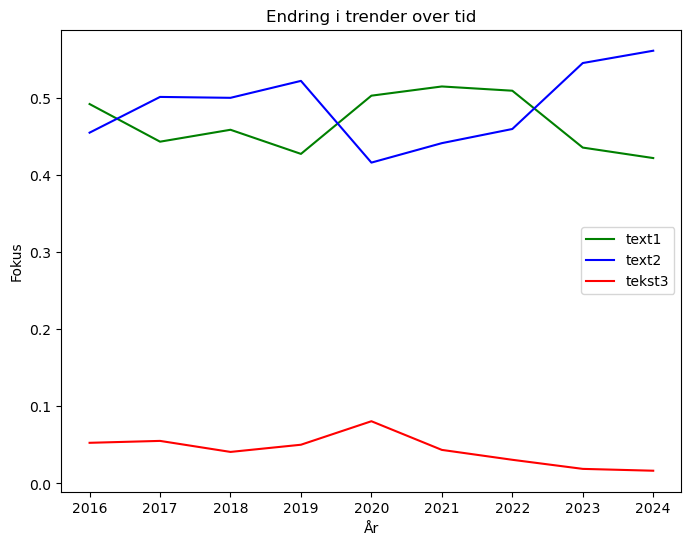

In [482]:
import matplotlib.pyplot as plt

years = range(2016, 2025)

# Sett opp plot
plt.figure(figsize=(8, 6))
plt.plot(years, centroid_1_values, 'g-', label="text1") #centroid1
plt.plot(years, centroid_2_values, 'b-', label="text2") #centroid2
plt.plot(years, centroid_3_values, 'r-', label="tekst3") #centroid3
plt.xlabel('År')
plt.ylabel('Fokus')
plt.title('Endring i trender over tid')

# Legg til en legend
plt.legend()

# Vis plottet
plt.show()


## Ett ord

In [483]:
text_embeddings = [embed_2016, embed_2024,embed_2023,embed_2022,embed_2021,embed_2020,embed_2019,embed_2018,embed_2017]

# Average the embeddings for each year
mean_embeddings = [emb.mean(dim=0).numpy() for emb in text_embeddings]

mean_embeddings


[array([-0.24312055,  0.5051784 ,  0.1549819 , ..., -0.6929625 ,
        -0.24416393,  0.20473239], dtype=float32),
 array([-0.24218343,  0.52749103,  0.07972469, ..., -0.6482674 ,
        -0.38613802,  0.06073271], dtype=float32),
 array([-0.29241958,  0.46201125,  0.14774753, ..., -0.61416876,
        -0.35401216,  0.04904832], dtype=float32),
 array([-0.26597995,  0.5513826 ,  0.03799932, ..., -0.81161195,
        -0.4229434 ,  0.01807259], dtype=float32),
 array([-0.23074628,  0.52626956,  0.08668005, ..., -0.7644288 ,
        -0.36406428,  0.02450266], dtype=float32),
 array([-0.22474691,  0.5233269 , -0.01631049, ..., -0.7311823 ,
        -0.29212835,  0.04337287], dtype=float32),
 array([-0.24780482,  0.5994666 ,  0.07525771, ..., -0.7720047 ,
        -0.2908926 ,  0.16564277], dtype=float32),
 array([-0.20187528,  0.6276899 ,  0.10301138, ..., -0.74484354,
        -0.26047188,  0.18062863], dtype=float32),
 array([-0.29078484,  0.5914777 ,  0.13950814, ..., -0.7001572 ,
       

In [195]:
# Centroid: Ordet vi sammenlikner med

centroid = "Fueling the world safely and responsibly"
centroid_embedding = model.encode(centroid, convert_to_tensor=True).reshape(1, -1).tolist()


In [484]:
# Gir embeddingene en score basert på avstand til centroid-ordet

def embedding_score(text_embeddings, centroid_embedding,alpha):
    distances = sc.spatial.distance.cdist(mean_embeddings, centroid_embedding, "cosine")
    score = 1/(distances**alpha)
    sum = score.sum()
    return score/sum

In [485]:
scores = embedding_score(mean_embeddings, centroid_embedding, 5)

print(scores)

[[0.10805107]
 [0.07501585]
 [0.07231891]
 [0.10635723]
 [0.11118783]
 [0.11105685]
 [0.14402534]
 [0.12819543]
 [0.1437915 ]]


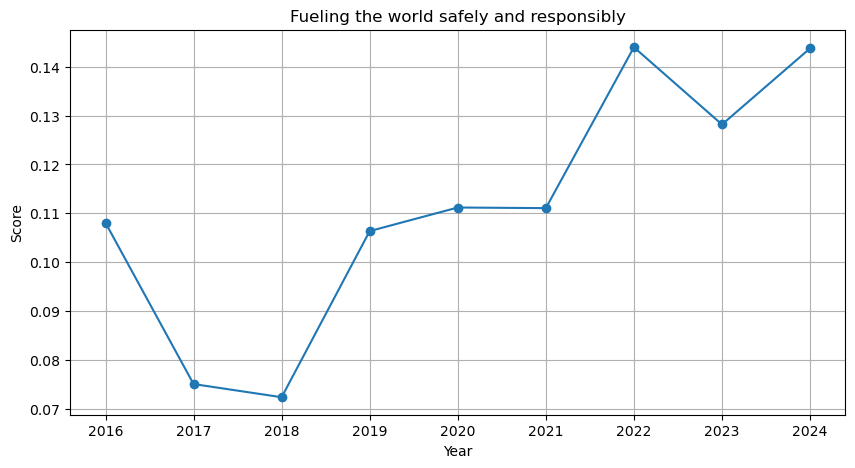

In [487]:
# Function to plot the scores with the centroid word as the title
def plot_scores(scores, centroid_word):
    years = list(range(2016, 2025))  # Assuming the years are from 2015 to 2024
    plt.figure(figsize=(10, 5))
    plt.plot(years, scores, marker='o')
    plt.title(f'Fueling the world safely and responsibly')
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# Plot the scores
plot_scores(scores, centroid)

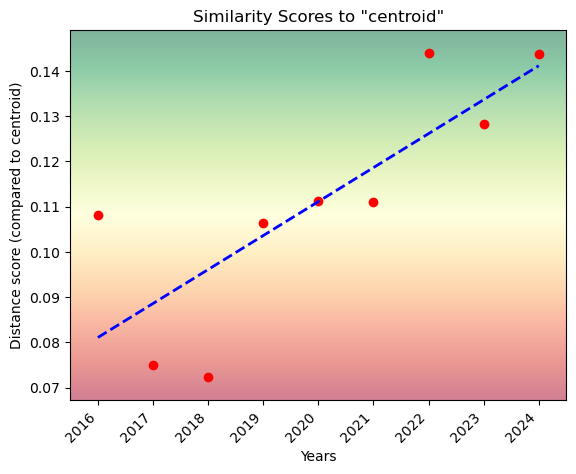

In [489]:
## Embedding scores by year

from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots()

years = np.array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

# Define the gradient
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient)).T

# Plot the gradient background directly on the axes
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn_r'), alpha=0.5, extent=[0, 1, 0, 1], transform=ax.transAxes)

# Customize the plot
plt.xlim(2015.5,2024.5)
plt.ylim(min(scores) - 0.005, max(scores) + 0.005)

ax.set_facecolor('none')

# Plot the data
plt.plot(years,scores,"ro")

plt.xticks(years, rotation=45, ha='right')

# Create and plot the line of best fit
X = years.reshape(-1, 1)
y = scores
regression = LinearRegression().fit(X, y)
y_pred = regression.predict(X)

plt.plot(years, y_pred, color='blue', linestyle='--', linewidth=2, label='Best Fit Line')


plt.xlabel("Years")
plt.ylabel(f"Distance score (compared to centroid)")
plt.title(f'Similarity Scores to "centroid"')


plt.show()

# Clustering 

## 2016

In [268]:
# Clustering
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2016) ##
cluster_assignment = clustering_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [269]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2016"][index]) ##

In [275]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 3

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2016) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2016"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2016',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2017

In [276]:
# Clustering
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2017) ##
cluster_assignment = clustering_model.labels_

In [277]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2017"][index]) ##

In [279]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 3

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2017) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2017"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2017',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2018

In [287]:
# Clustering
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2018) ##
cluster_assignment = clustering_model.labels_

In [288]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2018"][index]) ##

In [289]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 2

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2018) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2018"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2018', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2019

In [290]:
# Clustering
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2019) ##
cluster_assignment = clustering_model.labels_

In [291]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2019"][index]) ##

In [292]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 3

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2019) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2019"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2019', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2020

In [293]:
# Clustering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2020) ##
cluster_assignment = clustering_model.labels_

In [294]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2020"][index]) ##

In [295]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 3

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2020) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2020"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2020', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2021

In [296]:
# Clustering
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2021) ##
cluster_assignment = clustering_model.labels_

In [297]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2021"][index]) ##

In [300]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 3

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2021) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2021"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2021', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2022

In [311]:
# Clustering
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2022) ##
cluster_assignment = clustering_model.labels_

In [312]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2022"][index]) ##

In [313]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 2
unwanted_keywords = {"exxonmobil", "exxon", "exxon mobil"}

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=10)
    valid_keyword_found = False
    for kw, score in keywords:
        if kw.lower() not in unwanted_keywords:
            cluster_keywords.append(kw)
            valid_keyword_found = True
            break
    if not valid_keyword_found:
        cluster_keywords.append("No valid keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2022) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2022"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2022', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## 2023

In [307]:
# Clustering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embed_2023) ##
cluster_assignment = clustering_model.labels_

In [308]:
# Extract Articles from Clusters
clusters = [[] for i in range(num_clusters)]
for index, label in enumerate(cluster_assignment):
    clusters[label].append(split_content["2023"][index]) ##

In [309]:
import plotly.express as px
import plotly.graph_objects as go

antall_keywords = 2

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=1)
    if keywords:
        kw, score = keywords[0]
        cluster_keywords.append(kw)
    else:
        cluster_keywords.append("No keyword found")

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2023) ##

df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_assignment
df['Text'] = split_content["2023"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map[x])

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2023', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()

## HDBscan 2023

In [315]:
import hdbscan

# Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
cluster_labels = clusterer.fit_predict(embed_2023) ##

# Post-process to limit the number of clusters to 8
unique_clusters = np.unique(cluster_labels)
num_clusters = min(8, len(unique_clusters))
cluster_mapping = {old: new for new, old in enumerate(unique_clusters[:num_clusters])}
cluster_labels = np.array([cluster_mapping.get(label, -1) for label in cluster_labels])

In [316]:
# Extract Articles from Clusters
clusters = [[] for _ in range(num_clusters)]
for index, label in enumerate(cluster_labels):
    if label != -1:  # Exclude noise points labeled as -1
        clusters[label].append(split_content["2023"][index]) ##

# Keyword extraction with KeyBERT
antall_keywords = 3
kw_model = KeyBERT(model='all-MiniLM-L6-v2')
unwanted_keywords = {"exxonmobil", "exxon"}

cluster_keywords = []
for i, cluster in enumerate(clusters):
    combined_text = " ".join(cluster)
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, antall_keywords), stop_words='english', top_n=10)  # Increased top_n
    valid_keyword_found = False
    for kw, score in keywords:
        if kw.lower() not in unwanted_keywords:
            cluster_keywords.append(kw)
            valid_keyword_found = True
            break
    if not valid_keyword_found:
        cluster_keywords.append("No valid keyword found")

In [317]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embed_2023) ##

# Prepare the dataframe for plotting
df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df['Cluster'] = cluster_labels
df['Text'] = split_content["2023"] ##

# Create a color map for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
color_map = {i: colors[i] for i in range(num_clusters)}

# Assign colors to each cluster
df['Color'] = df['Cluster'].apply(lambda x: color_map.get(x, 'black'))  # Assign 'black' for noise points

# Create the scatter plot
fig = go.Figure()

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(color=color_map[cluster_num]),
        name=f'Cluster {cluster_num}: {cluster_keywords[cluster_num]}',
        text=cluster_data['Text'],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title='2023', ##
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster Keywords',
    showlegend=True
)

fig.show()


# Årsrapporter

In [318]:
# Laste ned og lese pdf-filer

def download_pdf(url, file_path):
    response = requests.get(url)
    with open(file_path, 'wb') as file:
        file.write(response.content)

def read_pdf(file_path):
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ''
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()
        return text
    except PyPDF2.errors.PdfReadError:
        print(f"Could not read the PDF file at {file_path}. It may be corrupted.")
        return None

In [319]:
urls = [
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-06-040951/0001193125-06-040951.pdf", #2005
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-07-042435/0001193125-07-042435.pdf", #2006
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-08-041781/0001193125-08-041781.pdf", #2007
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-09-040966/0001193125-09-040966.pdf", #2008
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-10-042929/0001193125-10-042929.pdf", #2009
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-11-047394/0001193125-11-047394.pdf", #2010
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0001193125-12-078102/0001193125-12-078102.pdf", #2011
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-13-000011/0000034088-13-000011.pdf", #2012
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-14-000012/0000034088-14-000012.pdf", #2013
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-15-000013/0000034088-15-000013.pdf", #2014
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-16-000065/0000034088-16-000065.pdf", #2015
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-17-000017/0000034088-17-000017.pdf", #2016
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-18-000015/0000034088-18-000015.pdf", #2017
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-19-000010/0000034088-19-000010.pdf", #2018
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-20-000016/0000034088-20-000016.pdf", #2019
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-21-000012/0000034088-21-000012.pdf", #2020
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-22-000011/0000034088-22-000011.pdf", #2021
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-23-000020/0000034088-23-000020.pdf", #2022
    "https://investor.exxonmobil.com/sec-filings/annual-reports/content/0000034088-24-000018/0000034088-24-000018.pdf", #2023
]

In [327]:
pdfs = []

for url in urls:
    file_path = 'annual_report.pdf'
    download_pdf(url, file_path)
    pdf_text = read_pdf(file_path)
    if pdf_text == None:
        print(f"Error")
    else:
        print(f"Correctly downloaded")
        pdfs.append(pdf_text)

combined_text = [" ".join(pdfs)]

Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded
Correctly downloaded


In [328]:
print(len(pdfs))

19


In [339]:
pdfs_by_year = {}

for i in range(len(pdfs)):
    pdfs_by_year[i+2005] = pdfs[i]

In [350]:
def split_up_pdfs(pdf, n): #husk at n må være mindre enn 512 (helst 500) for at modellen skal bruke hele!
    words = pdf.strip().split()
    if len(words) <= n :
        return [pdf]
    else:
        new_article = []
        for i in range(0, len(words), n):
            chunk = words[i:i+n]
            new_article.append(' '.join(chunk))
        return new_article

In [353]:
def split_pdf_content_by_year(pdfs_by_year, n):
    split_pdfs_by_year = {}

    for year, text in pdfs_by_year.items():
        split_pdfs_by_year[year] = []
        split_content = split_up_pdfs(text, n)
        split_pdfs_by_year[year].extend(split_content)

    return split_pdfs_by_year

split_content = split_pdf_content_by_year(pdfs_by_year,400)

In [ ]:
split_content[2012]

In [359]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [366]:
text_embeddings = []

def embed_pdfs(split_content):
    for year in split_content:
        embedding = model.encode(split_content[year], convert_to_tensor=True)
        print("Finished embedding")
        text_embeddings.append(embedding)

In [363]:
embedding_1 = model.encode(split_content[2005], convert_to_tensor=True)

embedding_1

tensor([[-0.3137,  0.7468,  0.6920,  ..., -0.4322, -0.2037,  0.0118],
        [-0.2945,  0.4000,  0.7600,  ..., -0.4595, -0.4627, -0.0146],
        [-0.5280,  0.3094, -0.2012,  ..., -0.6258, -0.4694,  0.2625],
        ...,
        [-0.4804, -0.4841,  0.6627,  ...,  0.0200,  0.0273,  0.1256],
        [-0.5257, -0.1853,  0.7443,  ..., -0.5067, -0.2046,  0.1883],
        [-0.3880, -0.1708,  0.6509,  ..., -0.4030,  0.2107, -0.1173]])

In [367]:
embed_pdfs(split_content)

text_embeddings

Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding
Finished embedding


[tensor([[-0.3137,  0.7468,  0.6920,  ..., -0.4322, -0.2037,  0.0118],
         [-0.2945,  0.4000,  0.7600,  ..., -0.4595, -0.4627, -0.0146],
         [-0.5280,  0.3094, -0.2012,  ..., -0.6258, -0.4694,  0.2625],
         ...,
         [-0.4804, -0.4841,  0.6627,  ...,  0.0200,  0.0273,  0.1256],
         [-0.5257, -0.1853,  0.7443,  ..., -0.5067, -0.2046,  0.1883],
         [-0.3880, -0.1708,  0.6509,  ..., -0.4030,  0.2107, -0.1173]]),
 tensor([[-0.4103,  0.5775,  0.8225,  ..., -0.5608, -0.1532,  0.0206],
         [-0.3987,  0.1961,  0.8824,  ..., -0.5678, -0.4825,  0.0384],
         [-0.8495,  0.3848, -0.1046,  ..., -0.6328, -0.3662,  0.2208],
         ...,
         [-0.6094, -0.4157,  0.9192,  ..., -0.1660,  0.1185,  0.1297],
         [-0.5291, -0.1421,  0.7439,  ..., -0.5692,  0.0570, -0.0753],
         [-0.5556,  0.0350,  0.3804,  ..., -0.2955, -0.1551, -0.4714]]),
 tensor([[-0.5069,  0.5934,  0.7219,  ..., -0.5591, -0.0754, -0.0627],
         [-0.3121,  0.4292,  0.9822,  ..., -0

In [368]:
exxon_embeddings_by_year = {}
for i in range(len(text_embeddings)):
    exxon_embeddings_by_year[i+2005] = text_embeddings[i]

exxon_embeddings_by_year

{2005: tensor([[-0.3137,  0.7468,  0.6920,  ..., -0.4322, -0.2037,  0.0118],
         [-0.2945,  0.4000,  0.7600,  ..., -0.4595, -0.4627, -0.0146],
         [-0.5280,  0.3094, -0.2012,  ..., -0.6258, -0.4694,  0.2625],
         ...,
         [-0.4804, -0.4841,  0.6627,  ...,  0.0200,  0.0273,  0.1256],
         [-0.5257, -0.1853,  0.7443,  ..., -0.5067, -0.2046,  0.1883],
         [-0.3880, -0.1708,  0.6509,  ..., -0.4030,  0.2107, -0.1173]]),
 2006: tensor([[-0.4103,  0.5775,  0.8225,  ..., -0.5608, -0.1532,  0.0206],
         [-0.3987,  0.1961,  0.8824,  ..., -0.5678, -0.4825,  0.0384],
         [-0.8495,  0.3848, -0.1046,  ..., -0.6328, -0.3662,  0.2208],
         ...,
         [-0.6094, -0.4157,  0.9192,  ..., -0.1660,  0.1185,  0.1297],
         [-0.5291, -0.1421,  0.7439,  ..., -0.5692,  0.0570, -0.0753],
         [-0.5556,  0.0350,  0.3804,  ..., -0.2955, -0.1551, -0.4714]]),
 2007: tensor([[-0.5069,  0.5934,  0.7219,  ..., -0.5591, -0.0754, -0.0627],
         [-0.3121,  0.4292,

In [416]:
with open("Exxon_pdfs.pkl","wb") as file:
    pickle.dump(exxon_embeddings_by_year, file)

## Ett ord

In [523]:
# Centroid: Ordet vi sammenlikner med

centroid = "recession"
centroid_embedding = model.encode(centroid, convert_to_tensor=True).cpu().numpy().reshape(1, -1)

print(centroid_embedding.shape)

(1, 1024)


In [491]:
with open('Exxon_pdfs.pkl', 'rb') as file:
    loaded_embeddings_by_year = pickle.load(file)

text_embeddings = list(loaded_embeddings_by_year.values())

# Average the embeddings for each year
mean_embeddings = [emb.mean(dim=0).numpy() for emb in text_embeddings]

mean_embeddings = np.stack(mean_embeddings)

# Verify the shape
print(f"Mean Embeddings shape: {mean_embeddings.shape}")

mean_embeddings


Mean Embeddings shape: (19, 1024)


array([[-0.22781669,  0.38537815,  0.19508766, ..., -0.53855574,
        -0.11800872,  0.02399045],
       [-0.30487993,  0.41544023,  0.2648207 , ..., -0.5337237 ,
        -0.09432547,  0.06944883],
       [-0.3451626 ,  0.35419983,  0.28743222, ..., -0.5534892 ,
        -0.0566364 ,  0.03825697],
       ...,
       [-0.26643488,  0.3507583 ,  0.05631249, ..., -0.60291594,
        -0.2515295 ,  0.02245692],
       [-0.23341753,  0.34383348,  0.03389307, ..., -0.611988  ,
        -0.20114759,  0.02349959],
       [-0.19571412,  0.3421345 ,  0.06696552, ..., -0.56078595,
        -0.23431873, -0.01734453]], dtype=float32)

In [434]:
for i in range(19):
    print(mean_embeddings[i].shape)

(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)


In [444]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [451]:
# Gir embeddingene en score basert på avstand til centroid-ordet

def embedding_score(mean_embeddings, centroid_embedding,alpha):
    distances = sc.spatial.distance.cdist(mean_embeddings, centroid_embedding, "cosine").flatten()
    score = 1/(distances**alpha)
    sum = score.sum()
    return score/sum

In [524]:
scores = embedding_score(mean_embeddings, centroid_embedding, 1)

print(scores)

[[0.05184481]
 [0.05176917]
 [0.05200679]
 [0.05299964]
 [0.05328179]
 [0.05333195]
 [0.05312064]
 [0.05264819]
 [0.05234187]
 [0.05178364]
 [0.0529137 ]
 [0.05235499]
 [0.05169085]
 [0.05172981]
 [0.05199414]
 [0.0533898 ]
 [0.05337514]
 [0.05364351]
 [0.05377957]]


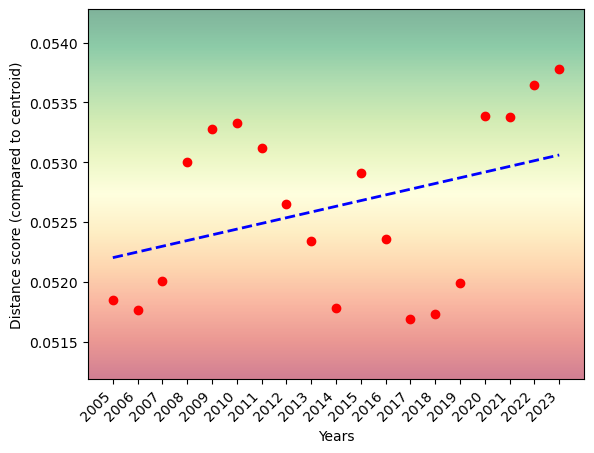

In [525]:
## Embedding scores by year

fig, ax = plt.subplots()

years = np.array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

# Define the gradient
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient)).T

# Plot the gradient background directly on the axes
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn_r'), alpha=0.5, extent=[0, 1, 0, 1], transform=ax.transAxes)

# Customize the plot
plt.xlim(2004,2024)
plt.ylim(min(scores) - 0.0005, max(scores) + 0.0005)

ax.set_facecolor('none')

# Plot the data
plt.plot(years,scores,"ro")

plt.xticks(years, rotation=45, ha='right')

# Create and plot the line of best fit
X = years.reshape(-1, 1)
y = scores
regression = LinearRegression().fit(X, y)
y_pred = regression.predict(X)

plt.plot(years, y_pred, color='blue', linestyle='--', linewidth=2, label='Best Fit Line')


plt.xlabel("Years")
plt.ylabel("Distance score (compared to centroid)")


plt.show()

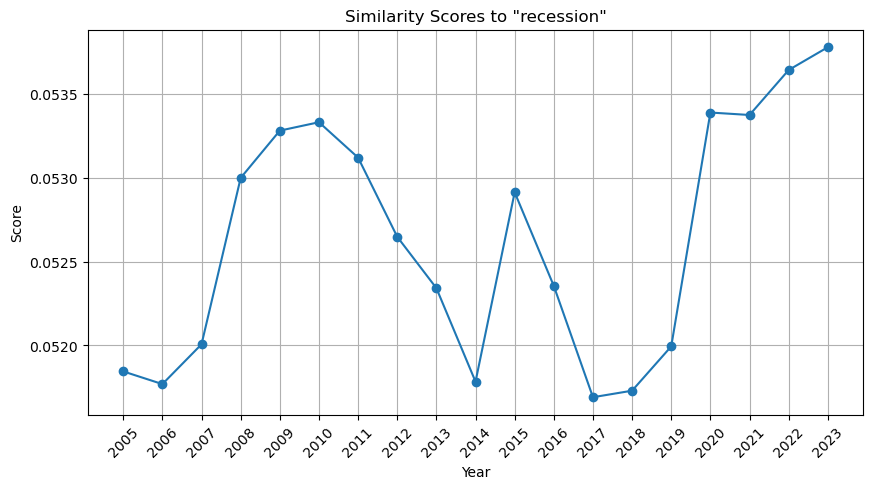

In [526]:
# Function to plot the scores with the centroid word as the title
def plot_scores(scores, centroid_word):
    years = list(range(2005, 2024))
    plt.figure(figsize=(10, 5))
    plt.plot(years, scores, marker='o')
    plt.title(f'Similarity Scores to "{centroid}"')
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.grid(True)

    # Set x-axis ticks to be whole years
    plt.xticks(years, rotation=45)
    
    plt.show()

# Plot the scores
plot_scores(scores, centroid)

## Flere ord

In [441]:
## funksjon for centroide embeddings
def centroid_embeddings(centroid_1, centroid_2, centroid_3):
    centroid_embedding_1 = model.encode(centroid_1, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_2 = model.encode(centroid_2, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_3 = model.encode(centroid_3, convert_to_tensor=True).reshape(1, -1)

    centroid_embeddings = [centroid_embedding_1, centroid_embedding_2, centroid_embedding_3]
    centroid_embeddings = np.array(centroid_embeddings)
    centroid_embeddings = np.squeeze(centroid_embeddings)

    return centroid_embeddings


## funksjon for embedding score
def embedding_score(text_embeddings, centroid_embeddings, alpha):

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric="cosine")

    # Scale and invert the distances according to the specified scaling
    score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    return score

## gir ut gjennomsnittlig fokus på trend
def mean_score(embed_score):      # tar inn scores
    mean_1=np.mean(embed_score[:,0])
    mean_2=np.mean(embed_score[:,1])
    mean_3=np.mean(embed_score[:,2])

    embedding_scores=[mean_1,mean_2,mean_3]
    return embedding_scores


In [447]:
centroid1= "Baptiste Oil and Gas invests in the development of CCS because this is in line with our corporate social responsibility policy. If we do not invest in this technology now, the amount of CO2 in the atmosphere will continue to increase, causing the mean temperature on earth to rise. This has several negative effects for humankind and nature, like disturbance of the present ecosystems, extinction of some plant- and animal species, and a rising sea level, with all its consequences. By implementing CCS on a large scale, less CO2 will be emitted into the air, which makes it possible to prevent the aforementioned ecological problems. In short, we invest in the development of CCS because of the natural environment."
centroid2= "Baptiste Oil and Gas invests in the development of CCS because we expect to profit from it in the long run. By being involved in the development of this technology, we gain important knowledge and experience. In the future, we can export this expertise. This will have beneficial effects on our turnover. Also, we expect to enhance our profit by trading our emission rights, the so-called emissions trade. Firms have the right to emit a certain amount of carbon dioxide. By using CCS, Baptiste Oil and Gas will emit almost no carbon dioxide but remains the rights to emit it. Therefore, we can sell our rights to other companies in order to enable them to emit more carbon dioxide than they are entitled to. In short, we invest in the development of CCS because of the profit."
centroid3= "better technology will resolve the climate changes"

centroids = centroid_embeddings(centroid1,centroid2,centroid3)
alpha = 15    # an initial alpha value


centroid_1_values = []
centroid_2_values = []
centroid_3_values = []

for i in text_embeddings:
    scores = embedding_score(i, centroids, alpha)
    mean=mean_score(scores)
    centroid_1_values.append(mean[0])
    centroid_2_values.append(mean[1])
    centroid_3_values.append(mean[2])


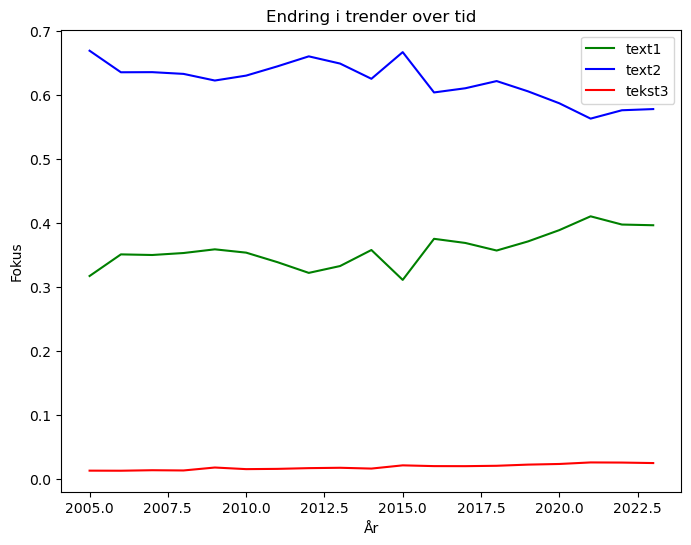

In [448]:
import matplotlib.pyplot as plt

years = range(2005, 2024)

# Sett opp plot
plt.figure(figsize=(8, 6))
plt.plot(years, centroid_1_values, 'g-', label="text1") #centroid1
plt.plot(years, centroid_2_values, 'b-', label="text2") #centroid2
plt.plot(years, centroid_3_values, 'r-', label="tekst3") #centroid3
plt.xlabel('År')
plt.ylabel('Fokus')
plt.title('Endring i trender over tid')

# Legg til en legend
plt.legend()

# Vis plottet
plt.show()
